In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.integrate as integrate
from scipy.stats import norm as normal

# Binary choice model

We consider a simple binary choice model, with the following utility functions:
- Alternative 1: $V_1 = 0$  
- Alternative 2: $V_2 = -\beta x$.
The exact value of $\beta$ is not known. It is known to be distributed across the population, following a normal distribution: 
 $$\beta \sim N(-1, 3^2).$$

In [2]:
mean = -1
scale = 3

The following function calculates the choice probability of alternative 1 if $\beta$ is known. It is a binary logit model:
$$
P(1; \beta) = \frac{1}{1 + e^{-\beta x}}
$$

In [3]:
def condprob(beta, x):
    return 1 / (1 + np.exp(-beta * x))

The following functions calculate the choice probability :
$$
P(1|x) = \int_{\beta=-\infty}^{+\infty}\frac{1}{1 + e^{-\beta x}} f(\beta) d\beta,
$$
where $f$ is the pdf of the normal distribution.

We first calculate the integral using quadrature methods. To do that, we define the integrand:

In [4]:
def integrand(beta, x):
    return condprob(beta, x) * normal.pdf(beta, loc=mean, scale=scale)

Then we integrate to obtain the choice probability.

In [5]:
def prob(x):
    return integrate.quad(integrand, -np.inf, +np.inf, args=x)[0]

The value for $x=1$ is calculated as follows. Note that some overflow warning may be produced.

In [6]:
quad_prob = prob(1)
quad_prob

<ipython-input-3-a889b5a0a8dc>:2: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-beta * x))


0.3867526054707759

We now compute the same quantity with Monte-Carlo integration.

We set the number of draws.

In [7]:
R = 50000

We generate draws from the normal distribution

In [8]:
beta = np.random.normal(loc=mean, scale=scale, size=R)

We calculate the conditional probability for each draw

In [9]:
mc_integrand = condprob(beta, 1) 

The Monte-Carlo estimation of the integral is the mean of the integrads.

In [10]:
mc_integrand.mean()

0.3887380679268334

In order to illustrate the process, we calculate the running mean, for all values of R. We first store all values of R.

In [11]:
mc_R = np.array(range(1,R+1))
mc_R

array([    1,     2,     3, ..., 49998, 49999, 50000])

Then, we calculate and plot the running average. The plot also includes an horizontal line corresponding to the value obtained by quadrature.

In [12]:
mc_integrand.cumsum()
res = mc_integrand.cumsum() / mc_R
res

array([0.52809108, 0.35086934, 0.56109491, ..., 0.38873566, 0.38874579,
       0.38873807])

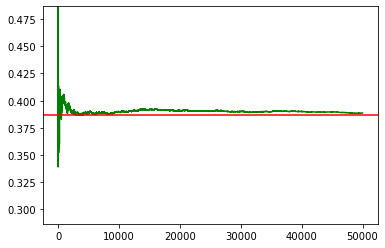

In [13]:
plt.plot(mc_R, res, color='g')
plt.axhline(y = quad_prob, color = 'r', linestyle = '-')
delta = 0.1
plt.ylim(quad_prob - delta, quad_prob + delta)
plt.show()

In order to calculate the confidence interval, we approximate the variance using the formula
$$
\text{Var}[g(\beta)] \approx \frac{1}{R} \sum_r g(\beta_r)^2 - \widehat{I}_R^2,
$$
where $g(x)$ is the conditional probability, and $\widehat{I}_R$ is the Monte-Carlo estimation of the integral.

In [14]:
mc_integrand_square = mc_integrand**2
var = mc_integrand_square.cumsum()/ mc_R - res**2

The 95\% confidence interval is $$[\widehat{I}- 1.96 e_R, \widehat{I}+ 1.96 e_R],$$ where $$e_R= \sqrt{\frac{\text{Var}[g(\beta)]}{R}}.$$

In [15]:
err = np.sqrt(var / mc_R)
err

array([0.        , 0.12531469, 0.19089957, ..., 0.00159971, 0.00159971,
       0.0015997 ])

We plot again the running average, together with the confidence interval. The parameter delta controls the range on the y-axis.

In [16]:
delta = 0.05

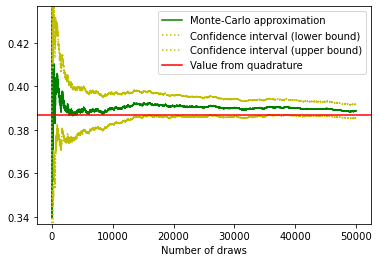

In [17]:
plt.plot(
    mc_R, 
    res, 
    color='g',
    label='Monte-Carlo approximation')
plt.plot(
    mc_R, 
    res - 1.96 * err, 
    color='y', 
    linestyle='dotted',
    label='Confidence interval (lower bound)'
)
plt.plot(
    mc_R, res + 1.96 * err, 
    color='y', 
    linestyle='dotted',
    label='Confidence interval (upper bound)'
)
plt.axhline(
    y = quad_prob, 
    color = 'r', 
    linestyle = '-',
    label='Value from quadrature')
plt.ylim(quad_prob - delta, quad_prob + delta)
plt.xlabel('Number of draws')
plt.legend()
plt.show()